In [4]:
import nltk
import pandas as pd
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import string
import csv
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from statistics import mean
from mpl_toolkits.mplot3d import axes3d,Axes3D

#nltk.downloader.download('stopwords')

In [5]:
weather_news = pd.read_csv("Unstructured_Data_Label.csv", index_col=None, header=0)

weather_news.head() #show the first 5 data

,title,date,label
0,Hurricane Dorian: Trump flies to golf club as ...,9/1/2019,mild
1,Hurricane Dorian: where will the storm hit and...,9/1/2019,moderate
2,A chilling truth: our addiction to air conditi...,9/1/2019,moderate
3,Hurricane Dorian strengthens to category 4 as ...,9/1/2019,severe
4,Floridians not fazed as Hurricane Dorian’s pat...,9/1/2019,mild


In [6]:
#Exploratory Data Analysis
weather_news.describe()
weather_news.groupby('label').describe()
weather_news['length'] = weather_news['title'].apply(len)
weather_news

,title,date,label,length
0,Hurricane Dorian: Trump flies to golf club as ...,9/1/2019,mild,78
1,Hurricane Dorian: where will the storm hit and...,9/1/2019,moderate,73
2,A chilling truth: our addiction to air conditi...,9/1/2019,moderate,60
3,Hurricane Dorian strengthens to category 4 as ...,9/1/2019,severe,73
4,Floridians not fazed as Hurricane Dorian’s pat...,9/1/2019,mild,68
5,Hurricane Dorian: millions evacuated from coas...,9/2/2019,severe,85
6,Hurricane Dorian lashes Bahamas with ferocious...,9/2/2019,severe,79
7,Hurricane Dorian: 'We're at the frontline of c...,9/5/2019,moderate,117
8,Sharpiegate': Trump insists Dorian was forecas...,9/5/2019,moderate,73
9,'Everything is destroyed': 30 dead in Bahamas ...,9/6/2019,severe,77


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C33F9F3C8>,
      dtype=object)

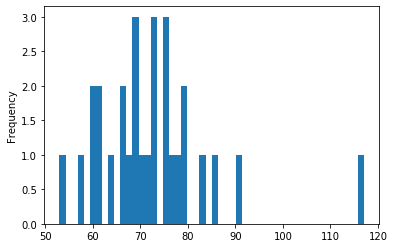

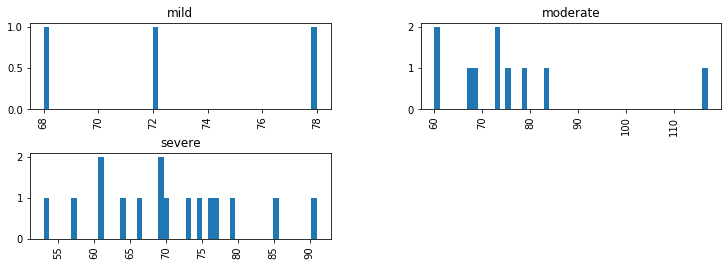

In [7]:
#plotting
weather_news['length'].plot(bins=50, kind='hist')
weather_news.length.describe()
weather_news.hist(column='length',by='label',bins=50,figsize=(12,4))

In [8]:
my_reader = csv.reader(open('Unstructured_Data_Label.csv'))
mild = 0
severe = 0
moderate = 0
for record in my_reader:
    if record[2] == 'mild':
        mild += 1
    elif record[2] == 'severe':
        severe += 1
    elif record[2] == 'moderate':
        moderate += 1
print("Mild: ",mild)
print("Severe: ",severe)
print("Moderate: ",moderate)

plt.show()

Mild:  3
Severe:  16
Moderate:  10


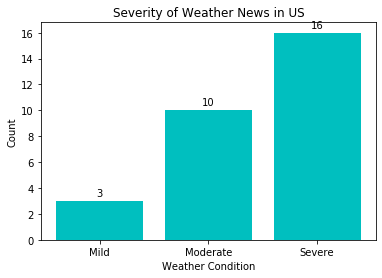

In [9]:
weather_cond = ('Mild', 'Moderate', 'Severe')
count = [mild,moderate,severe]
weather_post = [i for i, _ in enumerate(weather_cond)]

fig, ax = plt.subplots()
rects10 = ax.bar(weather_post, count, color='c')
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.title("Severity of Weather News in US")
plt.xticks(weather_post, weather_cond)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects10)
# Display the graph on the screen
plt.show()

In [23]:
##Text processing
def text_process(weather_news):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in weather_news if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    #if word.lower() not in stopwords.words('english')]

In [26]:
xgb_results = []
mlr_results = []
svm_results = []
rf_results = []

i = 1
for i in range(1,11):
  #Training set and test set
  news_train, news_test, label_train, label_test =\
  train_test_split(weather_news['title'],weather_news['label'],test_size=0.2)

  #Vectorizing text
  bow_transformer = CountVectorizer(analyzer = text_process).fit(weather_news["title"])
  bow_news = bow_transformer.transform(weather_news['title'])
  bow_news_train = bow_transformer.transform(news_train)
  bow_news_test = bow_transformer.transform(news_test)

  tfidf_transformer = TfidfTransformer().fit(bow_news)
  tfidf_news_train = tfidf_transformer.transform(bow_news_train)
  tfidf_news_test = tfidf_transformer.transform(bow_news_test)

  #Train model
  xgb = XGBClassifier(random_state=3).fit(tfidf_news_train, label_train)
  predictions_xgb = xgb.predict(tfidf_news_test)
  xgb_results.append(metrics.accuracy_score(label_test,predictions_xgb))
  
  mlr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',random_state=3).fit(tfidf_news_train, label_train)
  predictions_mlr = mlr.predict(tfidf_news_test)
  mlr_results.append(metrics.accuracy_score(label_test,predictions_mlr))
  
  svm = LinearSVC(random_state=3).fit(tfidf_news_train, label_train)
  predictions_svm = svm.predict(tfidf_news_test)
  svm_results.append(metrics.accuracy_score(label_test,predictions_svm))
 
  rf = RandomForestClassifier(n_estimators = 30,random_state=4)
  rf.fit(tfidf_news_train, label_train)
  predictions_rf = rf.predict(tfidf_news_test)
  rf_results.append(metrics.accuracy_score(label_test,predictions_rf))
  

print('Average accuracy for XGB for 10 iterations:', mean(xgb_results))
print('Average accuracy for MLR for 10 iterations:', mean(mlr_results))
print('Average accuracy for SVM for 10 iterations:', mean(svm_results))
print('Average accuracy for RF for 10 iterations:', mean(rf_results))

Average accuracy for XGB for 10 iterations: 0.6833333333333333
Average accuracy for MLR for 10 iterations: 0.5833333333333334
Average accuracy for SVM for 10 iterations: 0.5833333333333334
Average accuracy for RF for 10 iterations: 0.6


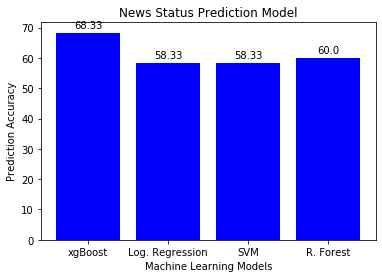

In [48]:
models = ('xgBoost', 'Log. Regression', 'SVM', 'R. Forest')
performance = [round(mean(xgb_results)*100,2),round(mean(mlr_results)*100,2),round(mean(svm_results)*100,2),round(mean(rf_results)*100,2)]
model_pos = [i for i, _ in enumerate(models)]

fig, ax = plt.subplots()
rects1 = ax.bar(model_pos, performance, color='b')
plt.xlabel("Machine Learning Models")
plt.ylabel("Prediction Accuracy")
plt.title("News Status Prediction Model")
plt.xticks(model_pos, models)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
# Display the graph on the screen
plt.show()